O modelo usado para o projeto é o Learning to Rank (Subcategoria da classificação), modelo que ordena uma lista de recomendação.

# 0.0 Imports

In [1]:
import pickle
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from flask   import Flask, request, Response
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

## 0.1 Loading Data

In [11]:
df = pd.read_csv( 'datasets/train.csv', low_memory=False )
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 Data Description

## 1.1 Data Dimension

In [3]:
print(f'Number of Rows {df.shape[0]}')
print(f'Number of Cols {df.shape[1]}')

Number of Rows 381109
Number of Cols 12


## 1.2 Data Types

In [4]:
df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

## 1.3 Check NA

In [5]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## 1.4 Variáveis

    id : ID exclusivo para o cliente
    
    Gender: Gênero do cliente
    
    Age: Idade do cliente
    
    Driving_License:

          0 : O cliente não tem DL, 
          1 : O cliente já tem DL

    Region_Code: Código para a região do cliente
    
    Previously_Insured:

          1 : Cliente já possui Seguro de Veículo, 
          0 : Cliente não tem Seguro de Veículo

    Vehicle_Age: Idade do Veículo
    
    Vehicle_Damage:

          1 : O cliente teve seu veículo danificado no passado. 
          0 : O cliente não teve seu veículo danificado no passado.

    Annual_Premium: O valor que o cliente pagou à empresa pelo seguro de saúde anual.
    
    PolicySalesChannel: Código anônimo para o canal de divulgação ao cliente, por exemplo, por correio, por telefone, pessoalmente, etc.
    
    Vintage: Número de dias que o cliente se associou à empresa através da compra do seguro de saúde.

    Response:

          1 : O cliente está interessado, 
          0 : O cliente não está interessado




## 1.5 Descriptive Statistical

In [13]:
num_attributes = df.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df.select_dtypes( include = ['object'])

### 1.5.1 Numerical Attributes

In [10]:
pd.options.display.float_format = '{:.2f}'.format
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00,381109.00,381108.00,190555.00,190555.00,110016.69,0.00,-1.20
1,Age,20.00,85.00,65.00,38.82,36.00,15.51,0.67,-0.57
2,Driving_License,0.00,1.00,1.00,1.00,1.00,0.05,-21.60,464.35
3,Region_Code,0.00,52.00,52.00,26.39,28.00,13.23,-0.12,-0.87
4,Previously_Insured,0.00,1.00,1.00,0.46,0.00,0.50,0.17,-1.97
5,Annual_Premium,2630.00,540165.00,537535.00,30564.39,31669.00,17213.13,1.77,34.00
6,Policy_Sales_Channel,1.00,163.00,162.00,112.03,133.00,54.20,-0.90,-0.97
7,Vintage,10.00,299.00,289.00,154.35,154.00,83.67,0.00,-1.20
8,Response,0.00,1.00,1.00,0.12,0.00,0.33,2.30,3.30


### 1.5.2 Categorical Attributes

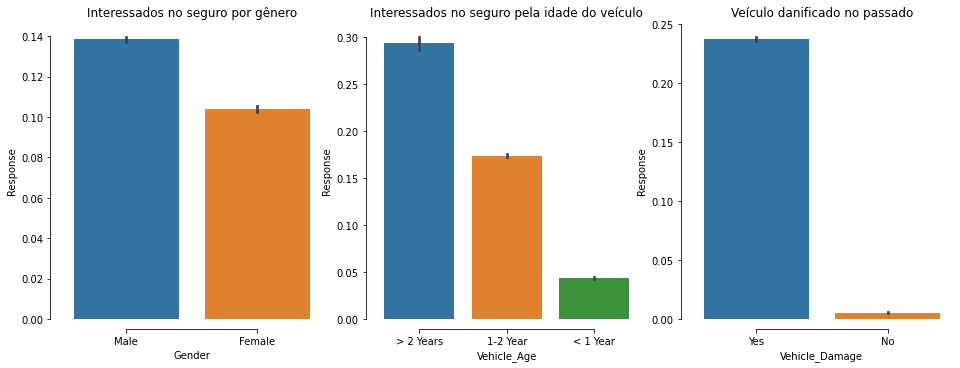

In [42]:
plt.figure(figsize=(16,12))
plt.subplot( 2, 3, 1 )
sns.barplot( x='Gender', y='Response', data=df )
# sns.despine(offset = 10, trim = True)
plt.title('Interessados no seguro por gênero')

plt.subplot( 2, 3, 2 )
sns.barplot( x='Vehicle_Age', y='Response', data=df )
sns.despine(offset = 10, trim = True)
plt.title('Interessados no seguro pela idade do veículo')

plt.subplot( 2, 3, 3 )
sns.barplot( x='Vehicle_Damage', y='Response', data=df )
sns.despine(offset = 10, trim = True)
plt.title('Veículo danificado no passado');

In [12]:
round(num_attributes['Response'].value_counts(normalize=True) *100 ,2)

0   87.74
1   12.26
Name: Response, dtype: float64

O dado acima demonstra que 12% dos clientes estão interessados em adquirir um seguro para o veículo.

# 2.0 Feature Engineering

In [78]:
#vehicle age
df['Vehicle_Age'] = df['Vehicle_Age'].apply( lambda x: 'over_2years' if x == '> 2 Years' else 'between_1_2years' 

                                                                       if x == '1-2 Year' else 'below_1_year')

#vehicle damage
df['Vehicle_Damage'] = df['Vehicle_Damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [2]:
# df.to_csv('datasets/df.csv', index_label=False )
df2 = pd.read_csv( 'datasets/df.csv', low_memory=False )

# 3.0 EDA

## 3.1 Univariate Analysis

### 3.1.1 Age

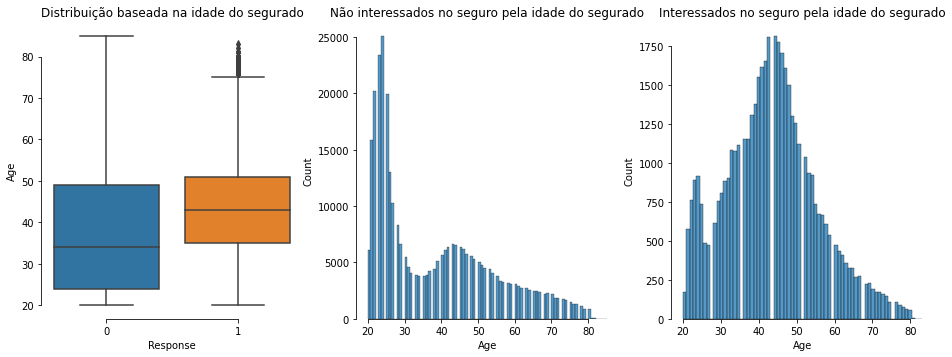

In [43]:
plt.figure(figsize=(16,12))

plt.subplot (2,3,1)
sns.boxplot( x='Response', y='Age', data=df2)
plt.title('Distribuição baseada na idade do segurado')
sns.despine(trim=True)

plt.subplot (2,3,2)
aux00 = df2.loc[df2['Response'] == 0, 'Age']
sns.histplot(aux00)
plt.title('Não interessados no seguro pela idade do segurado')
sns.despine(trim=True)

plt.subplot (2,3,3)
aux01 = df2.loc[df2['Response'] == 1, 'Age']
sns.histplot(aux01)
plt.title('Interessados no seguro pela idade do segurado');
sns.despine(trim=True)

Pessoas mais velhas, acima de 35 anos, tem mais interesse no seguro.

### 3.1.2 Annual Premium

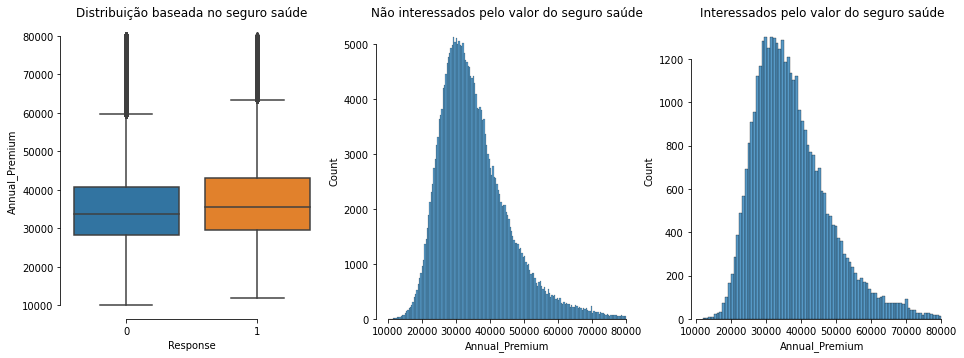

In [47]:
plt.figure(figsize=(16,12))

plt.subplot (2,3,1)
aux10 = df2[(df2['Annual_Premium'] > 10000) & (df2['Annual_Premium'] < 80000)]
sns.boxplot( x='Response', y='Annual_Premium', data=aux10)
plt.title('Distribuição baseada no seguro saúde')
sns.despine(trim=True)

plt.subplot (2,3,2)
aux11 = aux10.loc[aux10['Response'] == 0, 'Annual_Premium']
sns.histplot(aux11)
plt.title('Não interessados pelo valor do seguro saúde')
sns.despine(trim=True)

plt.subplot (2,3,3)
aux12 = aux10.loc[aux10['Response'] == 1, 'Annual_Premium']
sns.histplot(aux12)
plt.title('Interessados pelo valor do seguro saúde');
sns.despine(trim=True)

### 3.1.3 Driving Licence

,Response,Driving_License,Driving_License_Perc
0,0,333628,87.728276
1,1,46669,12.271724


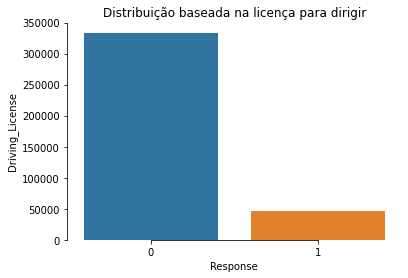

In [50]:
aux20 = df2[['Driving_License', 'Response']].groupby( 'Response' ).sum().reset_index()
aux20['Driving_License_Perc'] = (aux20['Driving_License']/aux20['Driving_License'].sum())*100

sns.barplot( x='Response', y='Driving_License', data=aux20)
sns.despine(trim=True)
plt.title('Distribuição baseada na licença para dirigir');

aux20.head()

### 3.1.4 Previously Insured

In [24]:
pd.crosstab(df2['Previously_Insured'], df2['Response']).apply(lambda x: (x/x.sum())*100, axis=1)

Response,0,1
Previously_Insured,,
0,77.45,22.55
1,99.91,0.09


Os dados acima demonstram que as pessoas não estão interessadas em assinar um novo seguro, pois 0,09% responderam ter interesse em assinar o seguro

### 3.1.5 Vehicle Age

In [25]:
df2[['Vehicle_Age', 'Response']].value_counts(normalize=True).reset_index()

,Vehicle_Age,Response,0
0,between_1_2years,0,0.43
1,below_1_year,0,0.41
2,between_1_2years,1,0.09
3,over_2years,0,0.03
4,below_1_year,1,0.02
5,over_2years,1,0.01


### 3.1.6 Policy Sales Channel

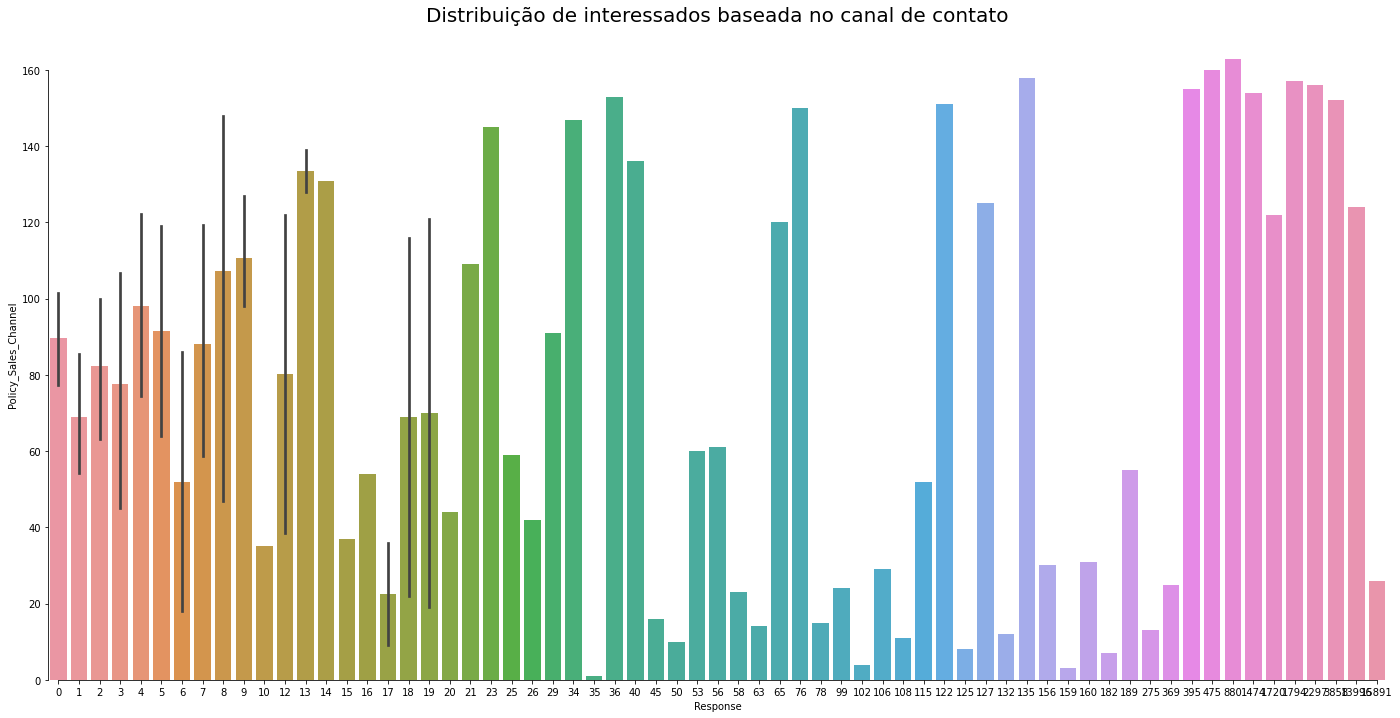

In [58]:
plt.figure( figsize=(24, 12) )
aux40 = df2[['Policy_Sales_Channel', 'Response']].groupby( 'Policy_Sales_Channel' ).sum().reset_index()
sns.barplot( x = 'Response', y = 'Policy_Sales_Channel', data = aux40)
sns.despine(trim=True)
plt.title('Distribuição de interessados baseada no canal de contato', fontsize=20);

### 3.1.7 Vintage

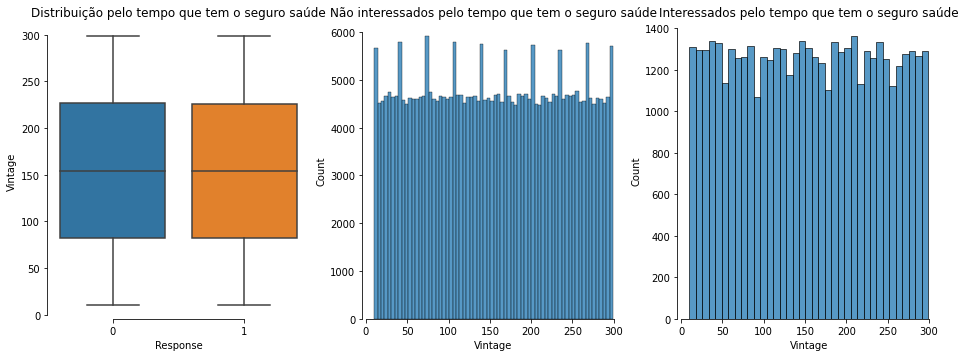

In [63]:
plt.figure(figsize=(16,12))

plt.subplot (2,3,1)
sns.boxplot( x='Response', y='Vintage', data=df2)
sns.despine(trim=True)
plt.title('Distribuição pelo tempo que tem o seguro saúde')

plt.subplot (2,3,2)
aux11 = df2.loc[df2['Response'] == 0, 'Vintage']
sns.histplot(aux11)
sns.despine(trim=True)
plt.title('Não interessados pelo tempo que tem o seguro saúde')

plt.subplot (2,3,3)
aux12 = df2.loc[df2['Response'] == 1, 'Vintage']
sns.histplot(aux12)
sns.despine(trim=True)
plt.title('Interessados pelo tempo que tem o seguro saúde');

# 4.0 Data Preparation

In [3]:
X = df2.drop( 'Response', axis=1 )
y = df2['Response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df3 = pd.concat( [x_train, y_train], axis=1)

In [32]:
# y_validation.to_csv('datasets/y_validation.csv', index_label=False )

## 4.1 Standartization

In [4]:
ss = pp.StandardScaler()

#Annual_Premium

df3['Annual_Premium'] = ss.fit_transform(df3[['Annual_Premium']].values)
# pickle.dump( ss, open('/home/alex/repos/repos/projeto_PA004/parameter/Annual_Premium_Scaler.pkl', 'wb'))

## 4.2 Recaling

In [5]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#Age

df3['Age'] = mms_age.fit_transform( df3[['Age']].values )
# pickle.dump( mms_age, open('/home/alex/repos/repos/projeto_PA004/parameter/Age_Scaler.pkl', 'wb'))

#Vintage

df3['Vintage'] = mms_vintage.fit_transform( df3[['Vintage']].values )
# pickle.dump( mms_vintage, open('/home/alex/repos/repos/projeto_PA004/parameter/Vintage_Scaler.pkl', 'wb'))

## 4.3 Encoder

In [6]:
#Gender - Target Encoding

te_Gender = df3.groupby( 'Gender' )[ 'Response' ].mean()
df3.loc[:, 'Gender'] = df3[ 'Gender' ].map( te_Gender )
# pickle.dump( te_Gender, open('/home/alex/repos/repos/projeto_PA004/parameter/Gender_Scaler.pkl', 'wb'))

#Region_Code - Target Encoding
te_region_code = df3.groupby( 'Region_Code' )[ 'Response' ].mean()
df3.loc[:, 'Region_Code'] = df3[ 'Region_Code' ].map( te_region_code )
# pickle.dump( te_region_code, open('/home/alex/repos/repos/projeto_PA004/parameter/Region_Code_Scaler.pkl', 'wb'))

#Vehicle_Age - One Hot Encoding

df3 = pd.get_dummies( df3, prefix = 'Vehicle_Age', columns = ['Vehicle_Age'])

#Policy_Sales_Channel - Frequency Encoding

fe_policy_sales_channel = df3.groupby( 'Policy_Sales_Channel' ).size() / len( df3 )
df3.loc[:, 'Policy_Sales_Channel'] = df3['Policy_Sales_Channel'].map(fe_policy_sales_channel)
# pickle.dump( fe_policy_sales_channel, open('/home/alex/repos/repos/projeto_PA004/parameter/Policy_Sales_Channel_Scaler.pkl', 'wb'))

## 4.4 Validation

In [7]:
#Gender

x_validation.loc[:, 'Gender' ] = x_validation.loc[:, 'Gender'].map(te_Gender)

#Age

x_validation.loc[:, 'Age'] = mms_age.transform( x_validation[['Age']].values )

#Region_Code

x_validation.loc[:, 'Region_Code'] = x_validation.loc[:, 'Region_Code' ].map( te_region_code )

#Vehicle_Age

x_validation = pd.get_dummies( x_validation, prefix = 'Vehicle_Age', columns = ['Vehicle_Age'])

#Annual_Premium

x_validation.loc[:, 'Annual_Premium'] = ss.transform(x_validation[['Annual_Premium']].values)

#Policy_Sales_Channel

x_validation.loc[:, 'Policy_Sales_Channel'] = x_validation['Policy_Sales_Channel'].map(fe_policy_sales_channel)

#Vintage

x_validation.loc[:, 'Vintage'] = mms_vintage.transform( x_validation[['Vintage']].values )

#fillna 

x_validation = x_validation.fillna( 0 )

# x_validation.to_csv('datasets/x_validation.csv', index_label=False )

# 5.0 Feature Selection

## 5.1 Features Importance

In [37]:
# # model definition

# forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1)

# #data preparation

# x_train_n = df3.drop(['id', 'Response'], axis=1)
# y_train_n = y_train.values
# forest.fit( x_train_n, y_train_n )

In [38]:
# importances = forest.feature_importances_
# std =np.std([forest.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# #print the feature ranking
# print("Feature ranking:")
# df = pd.DataFrame()
# for i, j in zip( x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature':i, 'importance':j}, index=[0])
#     df= pd.concat([df, aux], axis=0)

# print( df.sort_values( 'importance', ascending=False))

# # Plot the impurity_based feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# pl.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()

In [84]:
# df3.to_csv('datasets/df3.csv', index_label=False )

# 6.0 Machine Learning

In [9]:
df3 = pd.read_csv( 'datasets/df3.csv', low_memory=False )

In [10]:
y_validation = pd.read_csv( 'datasets/y_validation.csv', low_memory=False )

In [11]:
x_validation = pd.read_csv( 'datasets/x_validation.csv', low_memory=False )

In [8]:
cols_selected = ['Vintage', 'Annual_Premium', 'Age', 'Region_Code', 'Vehicle_Damage', 
                 'Policy_Sales_Channel', 'Previously_Insured'  ]

x_train = df3[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()

## 6.1 KNN

In [40]:
# #model definition
# knn_model = nh.kNeighborsClassifier( n_neighbors=2 )

# #model training
# knn_model.fit( x_train, y_train )

# #model prediction - Generalização
# yhat_knn = knn_model.predict_proba( x_val )

# # accumulative gain
# skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );


## 6.2 Logistic Regression

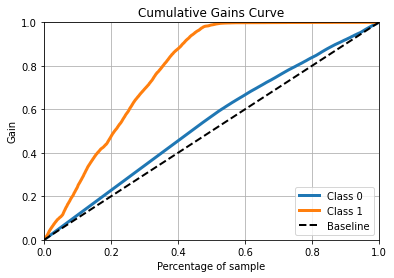

In [9]:
#model definition
lr_model = lm.LogisticRegression( random_state=42 )

#model training
lr_model.fit( x_train, y_train )

#model prediction - Generalização
yhat_lr = lr_model.predict_proba( x_val )

# accumulative gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

## 6.3 Extra Trees

In [42]:
# #model definition
# et = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# #model training
# et.fit( x_train, y_train)

# #model predict
# yhat_et = et.predict_proba( x_val )

# 7.0 Model Performance

In [66]:
y_validation = pd.read_csv( 'datasets/y_validation.csv', low_memory=False )
x_validation = pd.read_csv( 'datasets/x_validation.csv', low_memory=False )

In [88]:
# copy data

df4 = x_validation.copy()
df4['Response'] = y_validation.copy()

#propensity score

df4['Score']=yhat_lr[:, 1].tolist()

# sorted

df4 = df4.sort_values( 'Score', ascending=False )

In [89]:
''' Precision at k - De todos os exemplos que eu predisse como verdadeiro,
                     quantos realmente eram verdadeiros.'''
def precision_at_k( data, k=2000 ):

    #reset index

    data = data.reset_index( drop=True )

    #create ranking order

    data['Ranking'] = data.index + 1
    '''Predições corretas dividido pelas predições realizadas pelo modelo até k'''
    data['Precision_at_k'] = data['Response'].cumsum() / data['Ranking']
    data[['id', 'Response', 'Score', 'Ranking', 'Precision_at_k']].head()

    return data.loc[ k, 'Precision_at_k']

''' Recall at k - De todos os exemplos que são realmente verdadeiros, 
                  quantos foram preditos verdadeiros'''
def recall_at_k( data, k=2000 ):

    #reset index

    data = data.reset_index( drop=True )
    
    #create ranking order

    data['Ranking'] = data.index + 1
    '''Predições corretas até k dividido por todos os exemplos verdadeiros'''
    data['Recall_at_k'] = data['Response'].cumsum() / data['Response'].sum()
    data[['id', 'Response', 'Score', 'Ranking', 'Recall_at_k']].head()
    
    return data.loc[ k, 'Recall_at_k']

In [90]:
# compute precision at k

precision_at_50 = precision_at_k( df4, k=50 )
print ('Precision at k: {}'.format(precision_at_50))

# compute precision at k
recall_at_50 = recall_at_k( df4, k=50 )
print ('Recall at k: {}'.format(recall_at_50))

Precision at k: 0.1568627450980392
Recall at k: 0.0008546095502617242


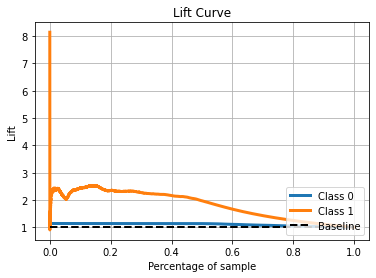

In [91]:
# lift curve
'''Curva Lift mostra quantas vezes o modelo é melhor que a média, 
   ou seja se fosse feito aleatóriamente'''
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

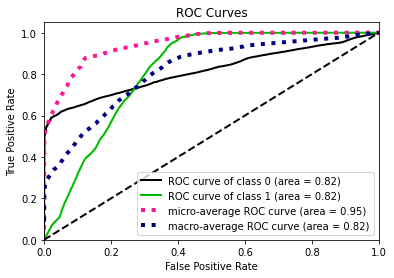

In [92]:
# ROC curve
skplt.metrics.plot_roc( y_val, yhat_lr );

# 8.0 Deploy to Production

In [47]:
# pickle.dump( lr_model, open('/home/alex/repos/repos/projeto_PA004/parameter/model_linear_regression.pkl', 'wb'))

## 8.1 Health Insurance Class

In [ ]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance:

    def __init__( self ):
       self.Annual_Premium_Scaler        = pickle.load( open ('/home/alex/repos/repos/projeto_PA004/parameter/Annual_Premium_Scaler.pkl', 'rb'))
       self.Age_Scaler                   = pickle.load( open ('/home/alex/repos/repos/projeto_PA004/parameter/Age_Scaler.pkl', 'rb'))
       self.Vintage_Scaler               = pickle.load( open ('/home/alex/repos/repos/projeto_PA004/parameter/Vintage_Scaler.pkl', 'rb'))
       self.Gender_Scaler                = pickle.load( open ('/home/alex/repos/repos/projeto_PA004/parameter/Gender_Scaler.pkl', 'rb'))
       self.Region_Code_Scaler           = pickle.load( open ('/home/alex/repos/repos/projeto_PA004/parameter/Region_Code_Scaler.pkl', 'rb'))
       self.Policy_Sales_Channel_Scaler  = pickle.load( open ('/home/alex/repos/repos/projeto_PA004/parameter/Policy_Sales_Channel_Scaler.pkl', 'rb'))

    def feature_engineering(self, df2):

       # vehicle age
       df2['Vehicle_Age'] = df2['Vehicle_Age'].apply( lambda x: 'over_2years' if x == '> 2 Years' else 'between_1_2years' 

                                                                              if x == '1-2 Year' else 'below_1_year')

       #vehicle damage
       df2['Vehicle_Damage'] = df2['Vehicle_Damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

       return df2

    def data_preparation(self, df3):

      #Annual_Premium
      df3['Annual_Premium'] = self.Annual_Premium_Scaler.transform(df3[['Annual_Premium']].values)

      #Age
      df3['Age'] = self.Age_Scaler.transform( df3[['Age']].values )

      #Vintage
      df3['Vintage'] = self.Vintage_Scaler.transform( df3[['Vintage']].values )

      #Gender - Target Encoding
      df3.loc[:, 'Gender'] = df3[ 'Gender' ].map( self.Gender_Scaler )

      #Region_Code - Target Encoding
      df3.loc[:, 'Region_Code'] = df3[ 'Region_Code' ].map( self.Region_Code_Scaler )

      #Vehicle_Age - One Hot Encoding
      df3 = pd.get_dummies( df3, prefix = 'Vehicle_Age', columns = ['Vehicle_Age'])

      #Policy_Sales_Channel - Frequency Encoding
      df3.loc[:, 'Policy_Sales_Channel'] = df3['Policy_Sales_Channel'].map(self.Policy_Sales_Channel_Scaler)

      #Feature Selection
      cols_selected = ['Vintage', 'Annual_Premium', 'Age', 'Region_Code', 'Vehicle_Damage', 

                       'Policy_Sales_Channel', 'Previously_Insured']

      return df3[ cols_selected ]


    def get_prediction( self, model, original_data, test_data):

      #model prediction
      pred = model.predict_proba( test_data )

      #join prediction into original data
      original_data['score'] = pred

      return original_data.to_json( orient='records', date_format='iso')

## 8.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

#loading model
model = pickle.load( open('/content/drive/My Drive/PA004/Model/model_linear_regression.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():

  test_json = request.get_json()

  if test_json: # test data
    if isinstance( test_json, dict ): #one row
      test_raw = pd.DataFrame(test_json, index=[0])

    else: #multiple rows
      test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

    #instantiate HealthInsurance class
    pipeline = HealthInsurance()

    #feature engineering
    df = pipeline.feature_engineering( test_raw )

    #data preparation
    df1 = pipeline.data_preparation(df)

    #prediction
    df_response = pipeline.get_prediction(model, test_raw, df3)

    return df_response

  else:
    return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':

  app.run('0.0.0.0', debug=True)

## 8.3 API Tester

In [1]:
import requests
import json
import pandas as pd

In [9]:
#loading test dataset

# y_validation = pd.read_csv( 'datasets/y_validation.csv', low_memory=False )
# x_validation = pd.read_csv( 'datasets/x_validation.csv', low_memory=False )

df_test = x_validation
df_test['response'] = y_validation

In [10]:
df_test = df_test.sample(10)
df_test = json.dumps(df_test.to_dict( orient='records'))

In [11]:
#API Call

#url = 'http://0.0.0.0:5000/predict'
url = 'https://healthinsurance-alex.herokuapp.com/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=df_test, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [12]:
dfn = pd.DataFrame(r.json(), columns=r.json()[0].keys())
dfn.sort_values( 'score', ascending=False).head(20)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_below_1_year,Vehicle_Age_between_1_2years,Vehicle_Age_over_2years,response,score
3,25964,None,-0.307456,1,None,0,0,-1.773541,None,-0.032579,1,0,0,0,0.027111
6,80730,None,-0.306036,1,None,0,0,-1.773531,None,-0.033345,1,0,0,0,0.027105
9,50326,None,-0.303195,1,None,0,0,-1.773564,None,-0.031321,0,1,0,0,0.027092
1,128277,None,-0.302249,1,None,0,0,-1.773514,None,-0.031788,0,1,0,0,0.027088
0,138577,None,-0.301538,1,None,0,0,-1.773563,None,-0.033692,0,1,0,0,0.027086
8,231033,None,-0.297988,1,None,0,0,-1.773522,None,-0.032064,0,1,0,0,0.027071
5,92664,None,-0.306509,1,None,1,0,-1.773565,None,-0.032471,1,0,0,0,0.000477
4,377774,None,-0.306509,1,None,1,0,-1.773496,None,-0.031369,1,0,0,0,0.000477
7,178062,None,-0.300592,1,None,1,0,-1.773502,None,-0.032255,0,1,0,0,0.000476
2,161442,None,-0.300355,1,None,1,0,-1.773559,None,-0.031142,0,1,0,0,0.000476


# 9 Business Performance

In [10]:
data = x_validation.copy()

data['Response'] = y_validation.copy()
data['Score'] = yhat_lr[:, 1].tolist()
data = data.sort_values('Score', ascending=False)

In [11]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_below_1_year,Vehicle_Age_between_1_2years,Vehicle_Age_over_2years,Response,Score
132757,132758,0.10398,0.400000,1,0.187382,0,1,16.083764,0.003313,0.602076,0,1,0,0,0.352374
353916,353917,0.13860,0.015385,1,0.187382,0,1,3.499192,0.001269,0.681661,1,0,0,0,0.344821
247966,247967,0.13860,0.015385,1,0.187382,0,1,2.695599,0.001584,0.851211,1,0,0,0,0.343258
268332,268333,0.13860,0.400000,1,0.187382,0,1,29.477946,0.194344,0.169550,0,1,0,0,0.343153
6747,6748,0.10398,0.107692,1,0.187382,0,1,3.925342,0.001994,0.114187,1,0,0,1,0.342237


# Utilizando 26% dos dados do teste, que representam 20 mil ligações da equipe de vendas, o modelo conseguiria identificar 61% das pessoas interessadas em adquirir o seguro.

In [121]:
percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k = 20000)

print(f' Percentual usado do dataset {round(percent_of_dataset, 2)*100} %')
print(f' De todos os verdadeiros foram preditos {round(recall_at_20000, 4)*100} %')

 Percentual usado do dataset 26.0 %
 De todos os verdadeiros foram preditos 61.0 %


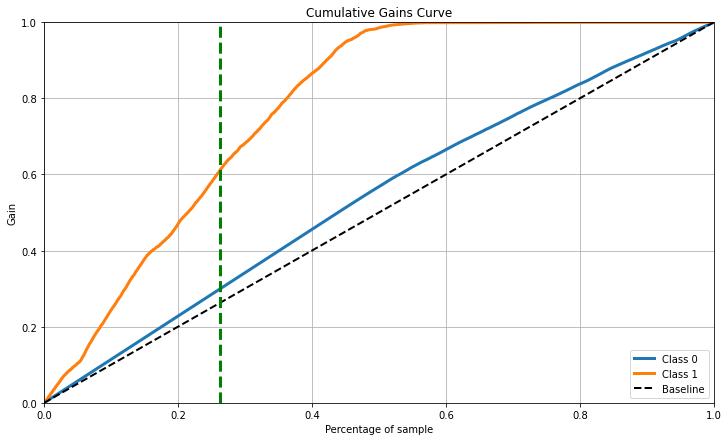

In [114]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr, figsize=(12,7))
plt.axvline(0.26239, 0, 1, color='green', ls='--', lw=3)
plt.show(); 

# Utilizando aproximadamente 40% dos dados de teste, que representam 30 mil ligações da equipe de vendas, o modelo conseguiria identificar mais de 85% das pessoas interessadas em adquirir o seguro.

In [123]:
percent_of_dataset = 30000 / len(data)
recall_at_30000 = recall_at_k(data, k = 30000)

print(f' Percentual usado do dataset {round(percent_of_dataset, 2)*100} %')
print(f' De todos os verdadeiros foram preditos {round(recall_at_30000, 4)*100} %')

 Percentual usado do dataset 39.0 %
 De todos os verdadeiros foram preditos 85.58 %


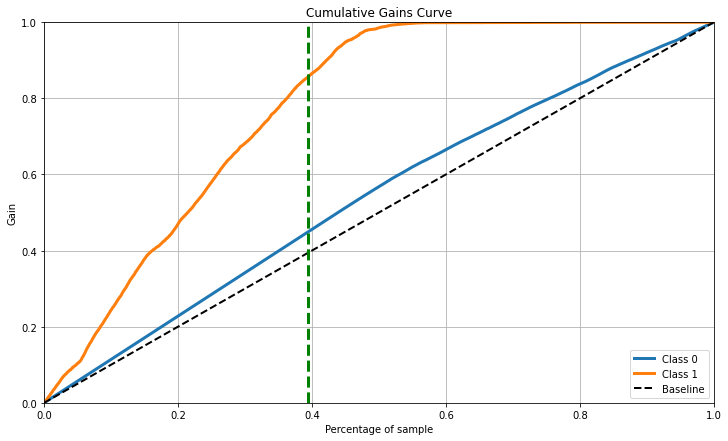

In [125]:
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr, figsize=(12,7))
plt.axvline(0.393587, 0, 1, color='green', ls='--', lw=3)
plt.show(); 

# Ao realizar 20 mil ligações, o modelo proposto é mais do que 2 vezes melhor do que a escolha aleatória, mantendo a performance 2 vezes melhor para 30 mil ligações.

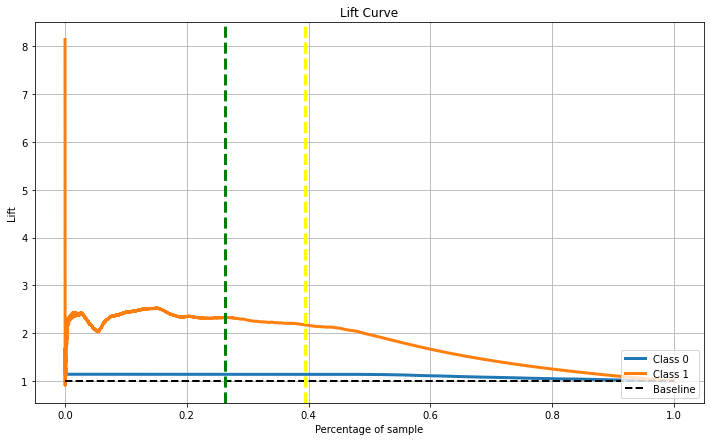

In [127]:
skplt.metrics.plot_lift_curve(y_validation, yhat_lr, figsize=(12,7))
plt.axvline(0.393587, 0, 1, color='yellow', ls='--', lw=3)
plt.axvline(0.26239, 0, 1, color='green', ls='--', lw=3);

# O modelo de média (Baseline) prevê 26% de todas as pessoas interessadas em seguros fazendo 20 mil ligações, enquanto nosso modelo prevê 61%. Se cada seguro for 1000 dólares  isso representa uma diferença de 29,6 milhões de dólares em 20 mil chamadas.

In [20]:
random_choice = (0.26) * len(data)
model         = (0.61) * len(data)

x = random_choice * 1000
y = model * 1000

print(f'Valor alcançado realizando 20 mil ligações aleatóriamente: {x}')
print(f'Valor alcançado realizando 20 mil ligações usando o modelo proposto: {y}')
print()
print(f'Diferença entre os dois modelos: {y-x}')
print()
print(f'O modelo proposto proporciona um ganho superior ao dobro do modelo aleatório')

Valor alcançado realizando 20 mil ligações aleatóriamente: 19817720.0
Valor alcançado realizando 20 mil ligações usando o modelo proposto: 46495420.0

Diferença entre os dois modelos: 26677700.0

O modelo proposto proporciona um ganho superior ao dobro do modelo aleatório


# Com 30 mil ligações, nosso modelo preveria 85% de todas as pessoas interessadas, e a diferença subiria para 35,5 milhões de dólares.

In [34]:
random_choice = (0.39) * len(data)
model         = (0.8558) * len(data)

x = random_choice * 1000
y = model * 1000

print(f'Valor alcançado realizando 30 mil ligações aleatóriamente: {x}')
print(f'Valor alcançado realizando 30 mil ligações usando o modelo proposto: {y}')
print()
print(f'Diferença entre os dois modelos: {y-x}')
print()
print(f'O modelo proposto mantém um ganho superior ao dobro do modelo aleatório')

Valor alcançado realizando 30 mil ligações aleatóriamente: 29726580.0
Valor alcançado realizando 30 mil ligações usando o modelo proposto: 65230787.6

Diferença entre os dois modelos: 35504207.6

O modelo proposto mantém um ganho superior ao dobro do modelo aleatório
